In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(font_scale=1.3, style='darkgrid', palette='Set2')

In [2]:
from enum import Enum
from collections import defaultdict

import brian2 as b2
import gym
from scipy.optimize import differential_evolution

import Walker750
from Walker750 import Side, Joint

import warnings
from warnings import filterwarnings
# filterwarnings(action='ignore')
filterwarnings(action='ignore', category=DeprecationWarning, module='.*brian2.*')
filterwarnings(action='ignore', category=DeprecationWarning, 
               message='.*the imp module is deprecated in favour of importlib and slated for.*')
filterwarnings(action='ignore', category=DeprecationWarning, 
               message='.*WARN: Initializing wrapper in old step API which returns one bool instead.*')
filterwarnings(action='ignore', category=DeprecationWarning,
               message='.*WARN: Initializing environment in old step API which returns one bool.*')
filterwarnings(action='ignore', category=UserWarning, 
               message='.*WARN: We recommend you to use a symmetric and normalized Box action space.*')

Медленное передвижение на колене и ступне

In [88]:
env = gym.make('BipedalWalker-v3')
env.seed(42 * 42)

[1764]

In [92]:
# params = [-0.607, -0.311, -1.649, -1.934,  # w1-w8
#            0.285, 0.143, 0.302, 0.151,     # tau
#            0.124, 0.770,                   # a
#            0.805, 3.078, -2.120, 2]        # u0, b, w, k_action

# env = gym.make('BipedalWalker-v3')
c = Walker750.Controller(w=[-0.607, 0, 0, -0.311, -1.649, 0, -1.934, 0],
               u_init={
                   Side.LEFT: {Joint.HIP: (0.4, -0.2), Joint.KNEE: (0, 0)},
                   Side.RIGHT: {Joint.HIP: (0.607, 0.95), Joint.KNEE: (0, 0)},
               },
               tau={
                   'u': {Joint.HIP: 0.285, Joint.KNEE: 0.143},
                   'v': {Joint.HIP: 0.302, Joint.KNEE: 0.151},
               }, a=(0.124, 0.770), u0=0.805, b=3.078,
               w_joint=-2.120, t_step=10 * b2.ms)
observation = env.reset()

for _ in range(3000):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1) * 1.75
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

In [116]:
def plot_u(controller, s, j, xlim=None, ylim=None):
    u1 = controller.joints[s][j].u_mon.u1[0]
    u2 = controller.joints[s][j].u_mon.u2[0]
    
    plt.figure(figsize=(9, 3))

    plt.title(f'{s.value} {j.value}')
    plt.plot(controller.joints[s][j].u_mon.t / b2.ms, u1, label='u1')
    plt.plot(controller.joints[s][j].u_mon.t / b2.ms, u2, label='u2')
    plt.plot(controller.joints[s][j].u_mon.t / b2.ms, np.maximum(0, u1) - np.maximum(0, u2), label='y', c='r', lw=4)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
        
    plt.ylabel('u')
    plt.xlabel('Время')
    plt.legend()
    plt.show()


def plot_all(controller, xlim=None):
    plot_u(controller, Side.LEFT, Joint.HIP, xlim, ylim=(-0.8, 1.7))
    plot_u(controller, Side.RIGHT, Joint.HIP, xlim, ylim=(-0.8, 1.7))
    plot_u(controller, Side.LEFT, Joint.KNEE, xlim, ylim=(-2.3, 1.7))
    plot_u(controller, Side.RIGHT, Joint.KNEE, xlim, ylim=(-2.3, 1.7))

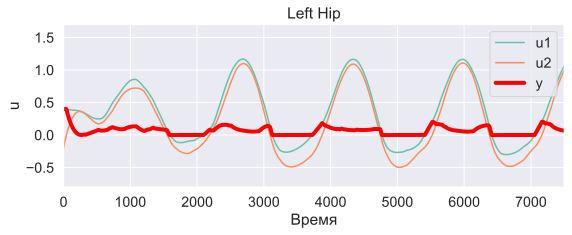

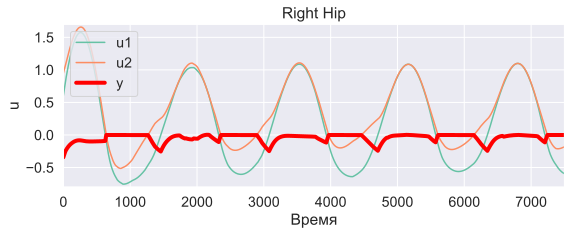

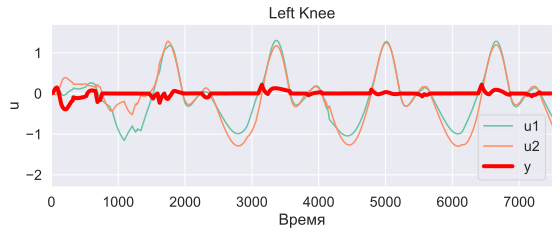

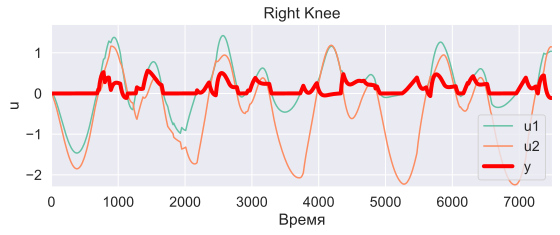

In [117]:
plot_all(c, (0, 7500))

In [42]:
env = gym.make('BipedalWalker-v3')
env.seed(42)

WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
 [py.warnings]


[42]

In [85]:
# params = [-0.607, -0.311, -1.649, -1.934,  # w1-w8
#            0.285, 0.143, 0.302, 0.151,     # tau
#            0.124, 0.770,                   # a
#            0.805, 3.078, -2.120, 2]        # u0, b, w, k_action

k_tau = 1

c = Walker750.Controller(w=[-0.607, 0, 0, -0.311, -1.649, 0, -1.934, 0],
               u_init={
                   Side.LEFT: {Joint.HIP: (0.45, 0.73), Joint.KNEE: (0.09, -0.2)},
                   Side.RIGHT: {Joint.HIP: (-0.5, -0.35), Joint.KNEE: (-0.45, 0.21)},
               },
               tau={
                   'u': {Joint.HIP: 0.285*k_tau, Joint.KNEE: 0.143*k_tau},
                   'v': {Joint.HIP: 0.302*k_tau, Joint.KNEE: 0.151*k_tau},
               }, a=(0.124, 0.770), u0=0.8, b=3.078,
               w_joint=-2.120, t_step=10 * b2.ms)
observation = env.reset()

for _ in range(3000):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1) * 1.8
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

KeyboardInterrupt: 

In [ ]:
env.close()

In [57]:
c = Walker750.Controller(w=[-0.607, 0, 0, -0.311, -1.649, 0, -1.934, 0],
               u_init={
                   Side.LEFT: {Joint.HIP: (0.3, -0.2), Joint.KNEE: (0, 0)},
                   Side.RIGHT: {Joint.HIP: (0.4, 0.95), Joint.KNEE: (0, 0)},
               },
               tau={
                   'u': {Joint.HIP: 0.285, Joint.KNEE: 0.143},
                   'v': {Joint.HIP: 0.302, Joint.KNEE: 0.151},
               }, a=(0.124, 0.770), u0=0.805, b=3.078,
               w_joint=-2.120, t_step=10 * b2.ms)

f = [[] for _ in range(4)]
for _ in tqdm(range(250)):
    c.step()
    f[0].append(c.f[Side.LEFT][Joint.HIP])
    f[1].append(c.f[Side.RIGHT][Joint.HIP])
    f[2].append(c.f[Side.LEFT][Joint.KNEE])
    f[3].append(c.f[Side.RIGHT][Joint.KNEE])

  0%|          | 0/250 [00:00<?, ?it/s]

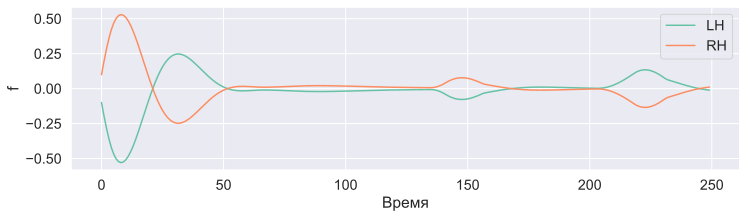

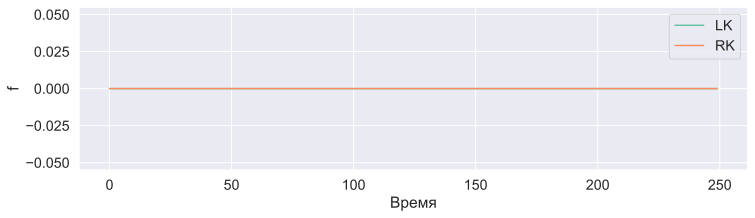

In [58]:
plt.figure(figsize=(12, 3))

plt.plot(f[0], label='LH')
plt.plot(f[1], label='RH')

plt.ylabel('f')
plt.xlabel('Время')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))

plt.plot(f[2], label='LK')
plt.plot(f[3], label='RK')

plt.ylabel('f')
plt.xlabel('Время')
plt.legend()
plt.show()

In [59]:
env = gym.make('BipedalWalker-v3')
observation = env.reset()

for _ in range(300):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1) * 1
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

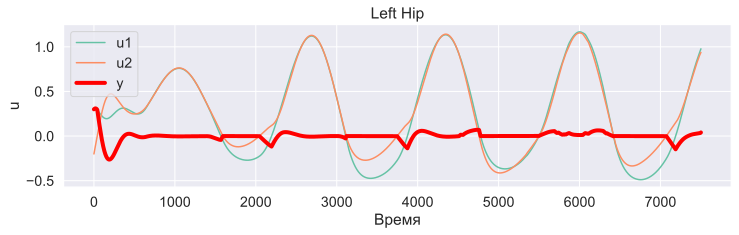

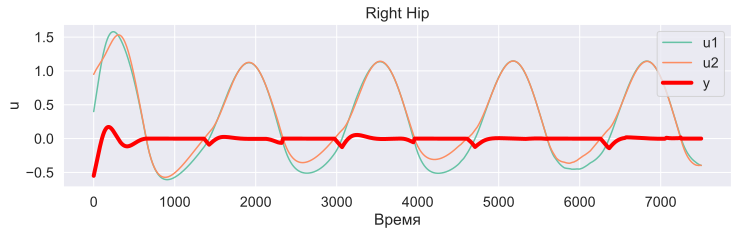

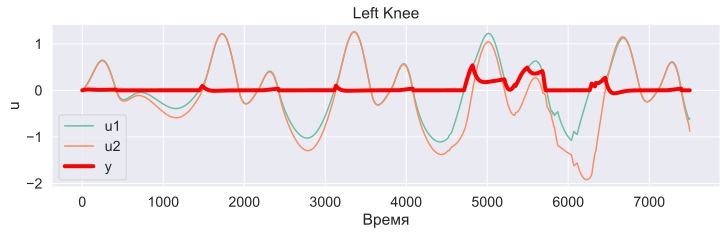

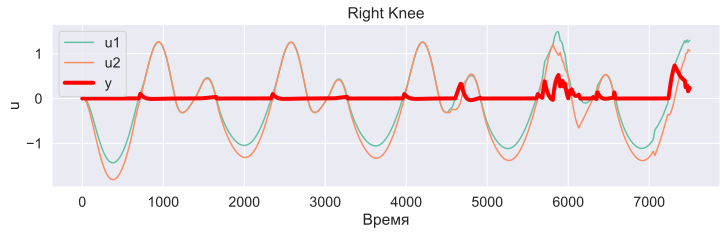

In [56]:
Walker750.plot_all(c)

In [40]:
# params = [-0.607, -0.311, -1.649, -1.934,  # w1-w8
#            0.285, 0.143, 0.302, 0.151,     # tau
#            0.124, 0.770,                   # a
#            0.805, 3.078, -2.120, 2]        # u0, b, w, k_action

env = gym.make('BipedalWalker-v3')
c = Walker750.Controller(w=[-0.607, 0, 0, -0.311, -1.649, 0, -1.934, 0],
               u_init={
                   Side.LEFT: {Joint.HIP: (0.3, -0.1), Joint.KNEE: (-0.9, -1.1)},
                   Side.RIGHT: {Joint.HIP: (0.6, 0.95), Joint.KNEE: (-1.1, -0.9)},
               },
               tau={
                   'u': {Joint.HIP: 0.285, Joint.KNEE: 0.143},
                   'v': {Joint.HIP: 0.302, Joint.KNEE: 0.151},
               }, a=(0.124, 0.770), u0=0.805, b=3.078,
               w_joint=-2.120, t_step=10 * b2.ms)
observation = env.reset()

for _ in range(300):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1) * 1
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

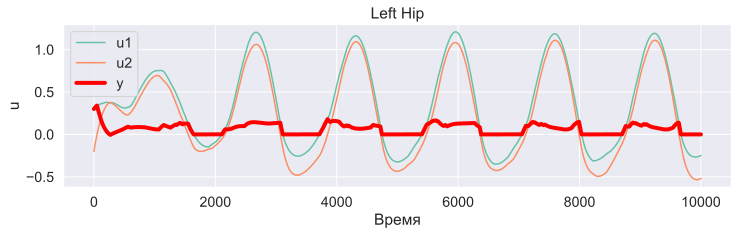

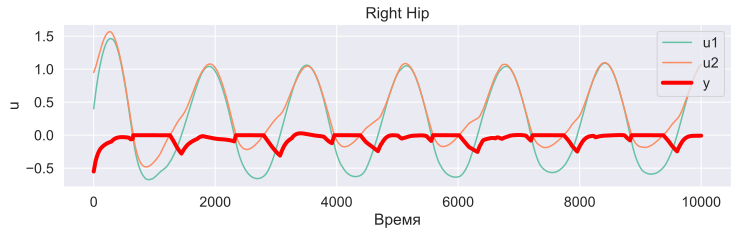

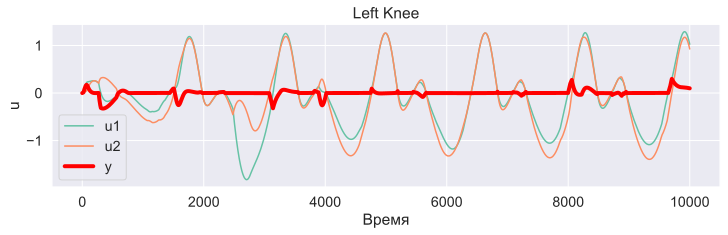

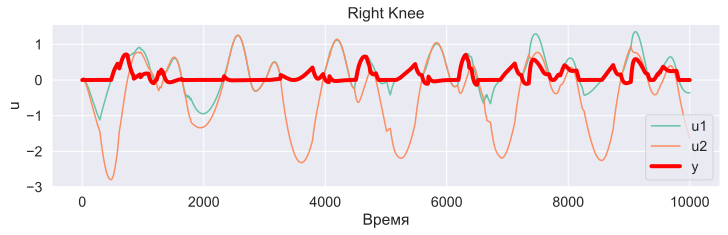

In [32]:
Walker750.plot_all(c)

In [11]:
params = [0.44924203, 0.72794723, -0.49852452, -0.35494599, 0.0859324, 
          -0.19954048, -0.44971128, 0.21221948, 0.84354148, 1.86184146]

c = Walker750.make_controller4(params)

env = gym.make('BipedalWalker-v3')
env.seed(291535460330709494348740156907463179829)
observation = env.reset()

for _ in range(5000):
    y = c.step(observation)
    action = np.array([y[Side.LEFT][Joint.HIP], y[Side.LEFT][Joint.KNEE], 
                       y[Side.RIGHT][Joint.HIP], y[Side.RIGHT][Joint.KNEE]])
    action = np.clip(action, -1, 1) * params[-1]
#     print(action)
    observation, reward, done, _ = env.step(action)
#     print(done, info)
#     print(reward)
    env.render()

env.close()

WARNING    /Users/aleks311001/mambaforge/envs/neuro/lib/python3.10/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
 [py.warnings]


KeyboardInterrupt: 

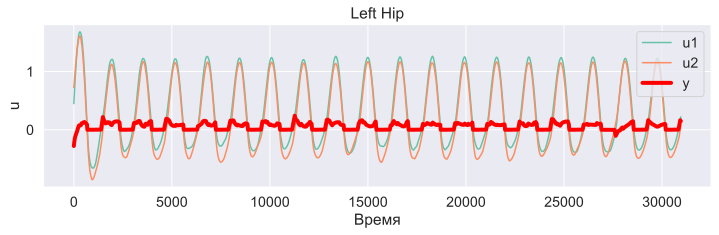

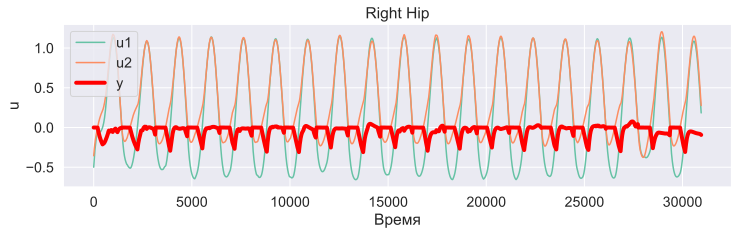

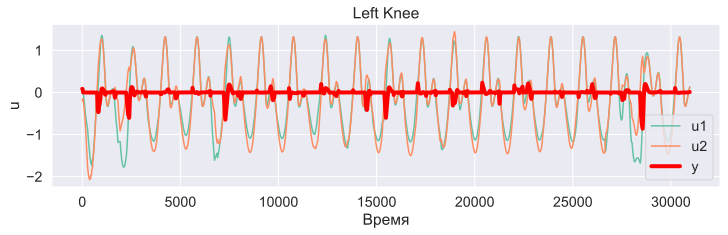

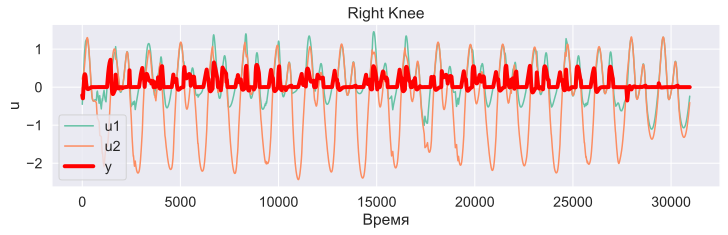

In [12]:
Walker750.plot_all(c)